In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
candidate_sentences = pd.read_csv("new.csv")
candidate_sentences.shape

(23, 2)

In [12]:
text=(
"Making a homemade sponge cake was never so easy."
"Begin by mixing sugar and butter together."
"Whisk well until light and fluffy with a manual whisker or a fork."
"Once done, add the beaten eggs and blend well."
"Beat further so that the mixture turns white and creamy."
"Sift together the all-purpose flour and baking soda."
"It is done to evenly distribute the baking soda in flour."
"Gradually, add this to the egg mixture."
"If required, add a little milk and mix till the batter is fluffy and soft."
"You may not add the entire milk if you feel the consistency of your cake is fine and it pours down like canned condensed milk."
"Add vanilla essence and blend well."
"Vanilla essence is important to camouflage the smell of eggs."
"Sprinkle some maida on a greased baking tin."
"It will prevent sticking of the cake to the base.
"You can also line it with a butter paper."
"Pour the prepared mixture into the tin and place it on a stand in a pressure cooker"
"Do not add water in the cooker and ensure that the tin does not touch the base of the cooker."
"You can also keep the baking dish on an inverted steel plate."
"Increase the flame and pressure cook for two minutes."
"Now remove the whistle and cook on low flame for 35-40 minutes."
"If you are using an electric oven, cook at 180 degrees for 30-35 minutes."
"Insert a knife or a metal skewer into the cake and if it comes out clean, then the cake is ready."
"Remove from the oven/cooker and allow to cool on a wire rack.")
doc = nlp(text)


SyntaxError: EOL while scanning string literal (<ipython-input-12-744699998627>, line 15)

In [9]:
print("Noun phrases:", [chunk.text for chunk in text.noun_chunks])

AttributeError: 'str' object has no attribute 'noun_chunks'

In [4]:
candidate_sentences['sentences'].sample(10)

6                                                                          It is done to evenly distribute the baking soda in flour.
3                                                                                     Once done, add the beaten eggs and blend well.
9     You may not add the entire milk if you feel the consistency of your cake is fine and it pours down like canned condensed milk.
13                                                                                 It will prevent sticking of the cake to the base.
8                                                         If required, add a little milk and mix till the batter is fluffy and soft.
18                                                                             Increase the flame and pressure cook for two minutes.
5                                                                               Sift together the all-purpose flour and baking soda.
0                                                                    

In [5]:
candidate_sentences.head()


,Unnamed: 0,sentences
0,0,Making a homemade sponge cake was never so easy.
1,1,Begin by mixing sugar and butter together.
2,2,Whisk well until light and fluffy with a manual whisker or a fork.
3,3,"Once done, add the beaten eggs and blend well."
4,4,Beat further so that the mixture turns white and creamy.


# 

In [6]:
def get_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      #Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix
      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
        #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + modifier

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]

In [7]:
[ent1,ent2] = get_entity("the film had 200 patents")
print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))
get_entity("the film had 200 patents")




Subj : film, obj : 200  patents


['film', '200  patents']

In [8]:
for i in tqdm(candidate_sentences['sentences']):
    [ent1,ent2] = get_entity(i)
    print("Subj : {a}, obj : {b}".format(a = ent1, b = ent2))

 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.83it/s]

Subj : Making, obj : homemade sponge cake
Subj : , obj : sugar
Subj : , obj : manual  whisker
Subj : , obj : beaten  eggs
Subj : further  mixture, obj : 
Subj : , obj : together  soda
Subj : It, obj : baking  flour
Subj : , obj : Gradually egg mixture
Subj : little  batter, obj : little  milk
Subj : entire  it, obj : condensed  milk
Subj : , obj : vanilla essence
Subj : Vanilla essence, obj : eggs

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [00:00<00:00, 59.95it/s]


Subj : , obj : greased baking tin
Subj : It, obj : base
Subj : You, obj : also butter paper
Subj : , obj : prepared pressure cooker
Subj : tin, obj : cooker
Subj : You, obj : inverted steel plate
Subj : , obj : two pressure minutes
Subj : , obj : 35  minutes
Subj : you, obj : 35  minutes
Subj : then  cake, obj : metal cake

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 62.14it/s]


Subj : , obj : oven wire rack


In [9]:
entity_pairs = []
for i in tqdm(candidate_sentences['sentences']):
    entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 79.25it/s]


In [10]:
entity_pairs = []
for i in tqdm(candidate_sentences['sentences']):
    entity_pairs.append(get_entity(i))
    for i in range(len(entity_pairs)):
        print(entity_pairs[i])       

 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 69.73it/s]

['Making', 'homemade sponge cake']
['Making', 'homemade sponge cake']
['', 'sugar']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['It', 'baking  flour']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['It', 'baking  flour']
['', 'Gradually egg mixture']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 't

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:00<00:00, 60.14it/s]

['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['It', 'baking  flour']
['', 'Gradually egg mixture']
['little  batter', 'little  milk']
['entire  it', 'condensed  milk']
['', 'vanilla essence']
['Vanilla essence', 'eggs']
['', 'greased baking tin']
['It', 'base']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['It', 'baking  flour']
['', 'Gradually egg mixture']
['little  batter', 'little  milk']
['entire  it', 'condensed  milk']
['', 'vanilla essence']
['Vanilla essence', 'eggs']
['', 'greased baking tin']
['It', 'base']
['You', 'also butter paper']
['Making', 'homemade sponge cake']
['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['It', 'baking  flour']
['', 'Gradually egg mixture']
['little  batter', 'little  milk']
['entire  it', 'conden

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 56.71it/s]


['', 'sugar']
['', 'manual  whisker']
['', 'beaten  eggs']
['further  mixture', '']
['', 'together  soda']
['It', 'baking  flour']
['', 'Gradually egg mixture']
['little  batter', 'little  milk']
['entire  it', 'condensed  milk']
['', 'vanilla essence']
['Vanilla essence', 'eggs']
['', 'greased baking tin']
['It', 'base']
['You', 'also butter paper']
['', 'prepared pressure cooker']
['tin', 'cooker']
['You', 'inverted steel plate']
['', 'two pressure minutes']
['', '35  minutes']
['you', '35  minutes']
['then  cake', 'metal cake']
['', 'oven wire rack']


In [11]:
subjects = []
objects = []
subjects = [x[0] for x in entity_pairs]
objects = [x[1] for x in entity_pairs]

In [12]:
def get_relation(sent):
  doc = nlp(sent)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'agent','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  #Adding the pattern to the matcher
  matcher.add("matcher_1",[pattern])
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  span = doc[matches[0][1]:matches[0][2]]
  return span.text

In [13]:
get_entity("John completed the task"), get_relation("John completed the task")

(['John', 'task'], 'completed')

In [14]:

for i in tqdm(candidate_sentences['sentences']):
    for j in tqdm(candidate_sentences['sentences']):
        print(get_entity(i),get_relation(j))

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['Making', 'homemade sponge cake'] was
['Making', 'homemade sponge cake']


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 35.01it/s]

 Begin
['Making', 'homemade sponge cake'] Whisk
['Making', 'homemade sponge cake'] add
['Making', 'homemade sponge cake'] Beat
['Making', 'homemade sponge cake'] Sift
['Making', 'homemade sponge cake']


 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 32.18it/s]

 done



 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 26.15it/s]

['Making', 'homemade sponge cake'] add
['Making', 'homemade sponge cake'] add
['Making', 'homemade sponge cake'] add
['Making', 'homemade sponge cake']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 23.92it/s]

 Add



 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:00<00:00, 22.13it/s]

['Making', 'homemade sponge cake'] is
['Making', 'homemade sponge cake'] Sprinkle
['Making', 'homemade sponge cake'] prevent
['Making', 'homemade sponge cake'] line
['Making', 'homemade sponge cake']


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 24.89it/s]

 Pour
['Making', 'homemade sponge cake'] add
['Making', 'homemade sponge cake']


 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:00<00:00, 26.95it/s]

 keep
['Making', 'homemade sponge cake'] Increase
['Making', 'homemade sponge cake'] remove
['Making', 'homemade sponge cake'] cook
['Making', 'homemade sponge cake']

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 is
['Making', 'homemade sponge cake'] Remove
['', 'sugar'] was
['', 'sugar']


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 39.89it/s]

 Begin
['', 'sugar'] Whisk
['', 'sugar'] add
['', 'sugar'] Beat
['', 'sugar']


 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 39.44it/s]

 Sift
['', 'sugar'] done
['', 'sugar'] add
['', 'sugar'] add
['', 'sugar'] add
['', 'sugar'] Add
['', 'sugar'] is
['', 'sugar']


 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:00<00:00, 40.08it/s]

 Sprinkle
['', 'sugar'] prevent
['', 'sugar'] line
['', 'sugar'] Pour
['', 'sugar'] add
['', 'sugar']


 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:00<00:00, 39.13it/s]

 keep
['', 'sugar'] Increase
['', 'sugar']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 remove
['', 'sugar'] cook
['', 'sugar'] is
['', 'sugar'] Remove
['', 'manual  whisker'] was
['', 'manual  whisker'] Begin
['', 'manual  whisker'] Whisk
['', 'manual  whisker']


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 37.97it/s]

 add
['', 'manual  whisker'] Beat
['', 'manual  whisker'] Sift
['', 'manual  whisker'] done
['', 'manual  whisker'] add
['', 'manual  whisker']


 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 38.57it/s]

 add
['', 'manual  whisker'] add
['', 'manual  whisker']


 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:00<00:00, 36.82it/s]

 Add
['', 'manual  whisker'] is
['', 'manual  whisker'] Sprinkle
['', 'manual  whisker'] prevent
['', 'manual  whisker'] line



 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 37.17it/s]

['', 'manual  whisker'] Pour
['', 'manual  whisker'] add
['', 'manual  whisker']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 keep
['', 'manual  whisker'] Increase
['', 'manual  whisker'] remove
['', 'manual  whisker'] cook
['', 'manual  whisker'] is
['', 'manual  whisker'] Remove
['', 'beaten  eggs'] was
['', 'beaten  eggs'] Begin
['', 'beaten  eggs'] Whisk
['', 'beaten  eggs']


 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 54.46it/s]

 add
['', 'beaten  eggs'] Beat
['', 'beaten  eggs'] Sift
['', 'beaten  eggs'] done
['', 'beaten  eggs'] add
['', 'beaten  eggs'] add
['', 'beaten  eggs']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 51.47it/s]

 add
['', 'beaten  eggs'] Add
['', 'beaten  eggs']


 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:00<00:00, 50.99it/s]

 is
['', 'beaten  eggs'] Sprinkle
['', 'beaten  eggs'] prevent
['', 'beaten  eggs'] line
['', 'beaten  eggs'] Pour
['', 'beaten  eggs'] add
['', 'beaten  eggs'] keep
['', 'beaten  eggs']


 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:00<00:00, 47.08it/s]

 Increase
['', 'beaten  eggs'] remove
['', 'beaten  eggs']

 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 49.88it/s]

 cook
['', 'beaten  eggs'] is
['', 'beaten  eggs'] Remove
['further  mixture', ''] was
['further  mixture', ''] Begin
['further  mixture', ''] Whisk
['further  mixture', ''] add
['further  mixture', ''] Beat
['further  mixture', ''] Sift
['further  mixture', '']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 49.95it/s]

 done
['further  mixture', ''] add
['further  mixture', ''] add
['further  mixture', ''] add
['further  mixture', ''] Add
['further  mixture', ''] is
['further  mixture', ''] Sprinkle
['further  mixture', ''] prevent
['further  mixture', ''] line
['further  mixture', '']


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 51.24it/s]

 Pour
['further  mixture', ''] add



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['further  mixture', ''] keep
['further  mixture', ''] Increase
['further  mixture', ''] remove
['further  mixture', ''] cook
['further  mixture', ''] is
['further  mixture', ''] Remove
['', 'together  soda'] was
['', 'together  soda'] Begin
['', 'together  soda'] Whisk
['', 'together  soda']


 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 50.00it/s]

 add
['', 'together  soda'] Beat
['', 'together  soda'] Sift
['', 'together  soda'] done
['', 'together  soda'] add
['', 'together  soda'] add
['', 'together  soda'] add
['', 'together  soda']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 51.16it/s]

 Add
['', 'together  soda'] is
['', 'together  soda'] Sprinkle
['', 'together  soda']


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 52.23it/s]

 prevent
['', 'together  soda'] line
['', 'together  soda'] Pour
['', 'together  soda'] add
['', 'together  soda'] keep
['', 'together  soda'] Increase
['', 'together  soda'] remove
['', 'together  soda']


 26%|█████████████████████▋                                                             | 6/23 [00:03<00:09,  1.79it/s]

 cook
['', 'together  soda'] is
['', 'together  soda'] Remove



 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 54.66it/s]

['It', 'baking  flour'] was
['It', 'baking  flour'] Begin
['It', 'baking  flour'] Whisk
['It', 'baking  flour'] add
['It', 'baking  flour'] Beat
['It', 'baking  flour'] Sift
['It', 'baking  flour'] done
['It', 'baking  flour'] add
['It', 'baking  flour'] add
['It', 'baking  flour'] add
['It', 'baking  flour']


 52%|██████████████████████████████████████████▊                                       | 12/23 [00:00<00:00, 53.14it/s]

 Add
['It', 'baking  flour'] is
['It', 'baking  flour'] Sprinkle
['It', 'baking  flour'] prevent
['It', 'baking  flour'] line
['It', 'baking  flour']


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 47.71it/s]

 Pour
['It', 'baking  flour'] add
['It', 'baking  flour']


 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:00<00:00, 41.57it/s]

 keep
['It', 'baking  flour'] Increase
['It', 'baking  flour'] remove
['It', 'baking  flour'] cook


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['It', 'baking  flour'] is
['It', 'baking  flour'] Remove
['', 'Gradually egg mixture']


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 39.99it/s]

 was
['', 'Gradually egg mixture'] Begin
['', 'Gradually egg mixture'] Whisk
['', 'Gradually egg mixture'] add
['', 'Gradually egg mixture'] Beat
['', 'Gradually egg mixture'] Sift
['', 'Gradually egg mixture'] done



 52%|██████████████████████████████████████████▊                                       | 12/23 [00:00<00:00, 37.31it/s]

['', 'Gradually egg mixture'] add
['', 'Gradually egg mixture'] add
['', 'Gradually egg mixture'] add
['', 'Gradually egg mixture'] Add
['', 'Gradually egg mixture'] is
['', 'Gradually egg mixture'] Sprinkle
['', 'Gradually egg mixture'] prevent
['', 'Gradually egg mixture']


 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:00<00:00, 36.52it/s]

 line
['', 'Gradually egg mixture'] Pour
['', 'Gradually egg mixture'] add
['', 'Gradually egg mixture'] keep
['', 'Gradually egg mixture'] Increase



 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:00<00:00, 35.08it/s]

['', 'Gradually egg mixture'] remove
['', 'Gradually egg mixture']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 cook
['', 'Gradually egg mixture'] is
['', 'Gradually egg mixture'] Remove
['little  batter', 'little  milk'] was
['little  batter', 'little  milk'] Begin
['little  batter', 'little  milk']


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 32.06it/s]

 Whisk
['little  batter', 'little  milk'] add
['little  batter', 'little  milk'] Beat
['little  batter', 'little  milk'] Sift
['little  batter', 'little  milk']


 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 32.42it/s]

 done
['little  batter', 'little  milk'] add
['little  batter', 'little  milk']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 31.63it/s]

 add
['little  batter', 'little  milk'] add
['little  batter', 'little  milk'] Add
['little  batter', 'little  milk'] is
['little  batter', 'little  milk'] Sprinkle
['little  batter', 'little  milk'] prevent



 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:00<00:00, 29.63it/s]

['little  batter', 'little  milk'] line
['little  batter', 'little  milk'] Pour
['little  batter', 'little  milk'] add



 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:00<00:00, 22.52it/s]

['little  batter', 'little  milk'] keep
['little  batter', 'little  milk'] Increase
['little  batter', 'little  milk']


 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:00<00:00, 22.34it/s]

 remove
['little  batter', 'little  milk'] cook
['little  batter', 'little  milk']

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 is
['little  batter', 'little  milk'] Remove
['entire  it', 'condensed  milk'] was
['entire  it', 'condensed  milk'] Begin
['entire  it', 'condensed  milk'] Whisk



 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 26.81it/s]

['entire  it', 'condensed  milk'] add
['entire  it', 'condensed  milk'] Beat
['entire  it', 'condensed  milk'] Sift



 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 23.30it/s]

['entire  it', 'condensed  milk'] done
['entire  it', 'condensed  milk'] add
['entire  it', 'condensed  milk'] add
['entire  it', 'condensed  milk']


 43%|███████████████████████████████████▋                                              | 10/23 [00:00<00:00, 20.31it/s]

 add
['entire  it', 'condensed  milk'] Add
['entire  it', 'condensed  milk']


 52%|██████████████████████████████████████████▊                                       | 12/23 [00:00<00:00, 18.44it/s]

 is
['entire  it', 'condensed  milk']


 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:00<00:00, 15.96it/s]

 Sprinkle
['entire  it', 'condensed  milk'] prevent
['entire  it', 'condensed  milk'] line
['entire  it', 'condensed  milk'] Pour



 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 18.05it/s]

['entire  it', 'condensed  milk'] add
['entire  it', 'condensed  milk'] keep
['entire  it', 'condensed  milk'] Increase
['entire  it', 'condensed  milk']


 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:01<00:00, 20.29it/s]

 remove
['entire  it', 'condensed  milk'] cook
['entire  it', 'condensed  milk']

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 is
['entire  it', 'condensed  milk'] Remove
['', 'vanilla essence'] was
['', 'vanilla essence'] Begin
['', 'vanilla essence']


 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 45.39it/s]

 Whisk
['', 'vanilla essence'] add
['', 'vanilla essence'] Beat
['', 'vanilla essence'] Sift
['', 'vanilla essence']


 43%|███████████████████████████████████▋                                              | 10/23 [00:00<00:00, 44.82it/s]

 done
['', 'vanilla essence'] add
['', 'vanilla essence'] add
['', 'vanilla essence'] add
['', 'vanilla essence']


 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:00<00:00, 43.25it/s]

 Add
['', 'vanilla essence'] is
['', 'vanilla essence'] Sprinkle
['', 'vanilla essence'] prevent



 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:00<00:00, 42.18it/s]

['', 'vanilla essence'] line
['', 'vanilla essence'] Pour
['', 'vanilla essence'] add
['', 'vanilla essence'] keep
['', 'vanilla essence'] Increase
['', 'vanilla essence'] remove
['', 'vanilla essence'] cook
['', 'vanilla essence']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 is
['', 'vanilla essence'] Remove
['Vanilla essence', 'eggs'] was
['Vanilla essence', 'eggs']

 Begin
['Vanilla essence', 'eggs'] Whisk
['Vanilla essence', 'eggs'] add
['Vanilla essence', 'eggs'] Beat


 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 40.85it/s]

['Vanilla essence', 'eggs'] Sift
['Vanilla essence', 'eggs'] done
['Vanilla essence', 'eggs'] add
['Vanilla essence', 'eggs'] 


 43%|███████████████████████████████████▋                                              | 10/23 [00:00<00:00, 40.83it/s]

add
['Vanilla essence', 'eggs'] add
['Vanilla essence', 'eggs'] Add
['Vanilla essence', 'eggs'] is
['Vanilla essence', 'eggs'] Sprinkle
['Vanilla essence', 'eggs']


 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:00<00:00, 41.09it/s]

 prevent
['Vanilla essence', 'eggs'] line
['Vanilla essence', 'eggs'] Pour
['Vanilla essence', 'eggs']


 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [00:00<00:00, 40.71it/s]

 add
['Vanilla essence', 'eggs'] keep
['Vanilla essence', 'eggs'] Increase
['Vanilla essence', 'eggs'] remove
['Vanilla essence', 'eggs'] cook


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['Vanilla essence', 'eggs'] is
['Vanilla essence', 'eggs'] Remove
['', 'greased baking tin'] was



 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 39.98it/s]

['', 'greased baking tin'] Begin
['', 'greased baking tin'] Whisk
['', 'greased baking tin'] add
['', 'greased baking tin'] Beat
['', 'greased baking tin'] Sift



 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 40.54it/s]

['', 'greased baking tin'] done
['', 'greased baking tin'] add
['', 'greased baking tin'] add



 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:00<00:00, 41.84it/s]

['', 'greased baking tin'] add
['', 'greased baking tin'] Add
['', 'greased baking tin'] is
['', 'greased baking tin'] Sprinkle
['', 'greased baking tin'] prevent
['', 'greased baking tin'] line
['', 'greased baking tin'] Pour
['', 'greased baking tin'] add
['', 'greased baking tin'] keep



 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:00<00:00, 39.98it/s]

['', 'greased baking tin'] Increase
['', 'greased baking tin'] remove
['', 'greased baking tin'] cook
['', 'greased baking tin'] is
['', 'greased baking tin']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 Remove
['It', 'base'] was
['It', 'base'] Begin
['It', 'base']


 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 42.83it/s]

 Whisk
['It', 'base'] add
['It', 'base'] Beat
['It', 'base'] Sift
['It', 'base']


 43%|███████████████████████████████████▋                                              | 10/23 [00:00<00:00, 42.48it/s]

 done
['It', 'base'] add
['It', 'base'] add
['It', 'base'] add
['It', 'base']

 Add
['It', 'base'] is
['It', 'base'] Sprinkle
['It', 'base'] prevent
['It', 'base'] line


 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:00<00:00, 43.42it/s]

['It', 'base'] Pour
['It', 'base'] add
['It', 'base']


 61%|█████████████████████████████████████████████████▉                                | 14/23 [00:09<00:05,  1.56it/s]


 keep
['It', 'base'] Increase
['It', 'base'] remove
['It', 'base'] cook
['It', 'base'] is
['It', 'base'] Remove


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['You', 'also butter paper'] was
['You', 'also butter paper'] Begin
['You', 'also butter paper']


 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 41.53it/s]

 Whisk
['You', 'also butter paper'] add
['You', 'also butter paper'] Beat
['You', 'also butter paper'] Sift
['You', 'also butter paper'] done
['You', 'also butter paper'] add
['You', 'also butter paper'] add
['You', 'also butter paper']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 44.84it/s]

 add
['You', 'also butter paper'] Add
['You', 'also butter paper'] is


 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 47.25it/s]


['You', 'also butter paper'] Sprinkle
['You', 'also butter paper'] prevent
['You', 'also butter paper'] line
['You', 'also butter paper'] Pour
['You', 'also butter paper'] add
['You', 'also butter paper'] keep
['You', 'also butter paper'] Increase
['You', 'also butter paper'] remove
['You', 'also butter paper'] cook
['You', 'also butter paper'] is
['You', 'also butter paper']


 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 50.72it/s]

 Remove
['', 'prepared pressure cooker'] was
['', 'prepared pressure cooker'] Begin
['', 'prepared pressure cooker'] Whisk
['', 'prepared pressure cooker'] add
['', 'prepared pressure cooker'] Beat
['', 'prepared pressure cooker'] Sift
['', 'prepared pressure cooker'] done
['', 'prepared pressure cooker'] add
['', 'prepared pressure cooker']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 48.88it/s]

 add
['', 'prepared pressure cooker'] add
['', 'prepared pressure cooker'] Add
['', 'prepared pressure cooker'] is
['', 'prepared pressure cooker'] Sprinkle
['', 'prepared pressure cooker'] prevent



 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:00<00:00, 44.15it/s]

['', 'prepared pressure cooker'] line
['', 'prepared pressure cooker']


 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [00:00<00:00, 42.27it/s]

 Pour
['', 'prepared pressure cooker'] add
['', 'prepared pressure cooker'] keep
['', 'prepared pressure cooker'] Increase
['', 'prepared pressure cooker'] remove
['', 'prepared pressure cooker'] cook
['', 'prepared pressure cooker']

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 is
['', 'prepared pressure cooker'] Remove



 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 42.85it/s]

['tin', 'cooker'] was
['tin', 'cooker'] Begin
['tin', 'cooker'] Whisk
['tin', 'cooker'] add
['tin', 'cooker'] Beat
['tin', 'cooker'] Sift
['tin', 'cooker'] done
['tin', 'cooker'] add
['tin', 'cooker']


 57%|██████████████████████████████████████████████▎                                   | 13/23 [00:00<00:00, 39.38it/s]

 add
['tin', 'cooker'] add
['tin', 'cooker'] Add
['tin', 'cooker'] is
['tin', 'cooker'] Sprinkle
['tin', 'cooker'] prevent
['tin', 'cooker'] line
['tin', 'cooker']


 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [00:00<00:00, 39.83it/s]

 Pour
['tin', 'cooker'] add
['tin', 'cooker'] keep
['tin', 'cooker'] Increase
['tin', 'cooker'] remove
['tin', 'cooker'] cook



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['tin', 'cooker'] is
['tin', 'cooker'] Remove
['You', 'inverted steel plate'] was
['You', 'inverted steel plate']


 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 30.63it/s]

 Begin
['You', 'inverted steel plate'] Whisk
['You', 'inverted steel plate'] add
['You', 'inverted steel plate'] Beat
['You', 'inverted steel plate'] Sift
['You', 'inverted steel plate'] done
['You', 'inverted steel plate'] add
['You', 'inverted steel plate'] add



 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [00:00<00:00, 35.16it/s]

['You', 'inverted steel plate'] add
['You', 'inverted steel plate'] Add
['You', 'inverted steel plate'] is
['You', 'inverted steel plate'] Sprinkle
['You', 'inverted steel plate'] prevent
['You', 'inverted steel plate'] line
['You', 'inverted steel plate'] Pour
['You', 'inverted steel plate'] add



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

['You', 'inverted steel plate'] keep
['You', 'inverted steel plate'] Increase
['You', 'inverted steel plate'] remove
['You', 'inverted steel plate'] cook
['You', 'inverted steel plate'] is
['You', 'inverted steel plate'] Remove
['', 'two pressure minutes'] was
['', 'two pressure minutes'] Begin
['', 'two pressure minutes']


 48%|███████████████████████████████████████▏                                          | 11/23 [00:00<00:00, 46.93it/s]

 Whisk
['', 'two pressure minutes'] add
['', 'two pressure minutes'] Beat
['', 'two pressure minutes'] Sift
['', 'two pressure minutes'] done
['', 'two pressure minutes'] add
['', 'two pressure minutes'] add
['', 'two pressure minutes'] add
['', 'two pressure minutes'] Add
['', 'two pressure minutes']


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [00:00<00:00, 49.35it/s]

 is
['', 'two pressure minutes'] Sprinkle
['', 'two pressure minutes'] prevent
['', 'two pressure minutes'] line
['', 'two pressure minutes'] Pour
['', 'two pressure minutes'] add
['', 'two pressure minutes'] keep
['', 'two pressure minutes'] Increase
['', 'two pressure minutes'] remove
['', 'two pressure minutes'] cook
['', 'two pressure minutes'] is


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 36.18it/s]

['', 'two pressure minutes'] Remove
['', '35  minutes'] was
['', '35  minutes'] Begin
['', '35  minutes'] Whisk
['', '35  minutes'] add
['', '35  minutes'] Beat
['', '35  minutes'] Sift
['', '35  minutes'] done



 65%|█████████████████████████████████████████████████████▍                            | 15/23 [00:00<00:00, 42.11it/s]

['', '35  minutes'] add
['', '35  minutes'] add
['', '35  minutes'] add
['', '35  minutes'] Add
['', '35  minutes'] is
['', '35  minutes'] Sprinkle
['', '35  minutes'] prevent
['', '35  minutes'] line
['', '35  minutes'] Pour
['', '35  minutes']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 add
['', '35  minutes'] keep
['', '35  minutes'] Increase
['', '35  minutes'] remove
['', '35  minutes'] cook
['', '35  minutes'] is
['', '35  minutes'] Remove
['you', '35  minutes'] was
['you', '35  minutes']


 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 43.15it/s]

 Begin
['you', '35  minutes'] Whisk
['you', '35  minutes'] add
['you', '35  minutes'] Beat
['you', '35  minutes'] Sift
['you', '35  minutes'] done



 52%|██████████████████████████████████████████▊                                       | 12/23 [00:00<00:00, 34.49it/s]

['you', '35  minutes'] add
['you', '35  minutes'] add
['you', '35  minutes'] add
['you', '35  minutes'] Add
['you', '35  minutes'] is
['you', '35  minutes'] Sprinkle
['you', '35  minutes'] prevent
['you', '35  minutes'] line



 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [00:00<00:00, 37.03it/s]

['you', '35  minutes'] Pour
['you', '35  minutes'] add
['you', '35  minutes'] keep
['you', '35  minutes'] Increase
['you', '35  minutes'] remove
['you', '35  minutes'] cook
['you', '35  minutes'] is
['you', '35  minutes']

 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 45.55it/s]

 Remove
['then  cake', 'metal cake'] was
['then  cake', 'metal cake'] Begin
['then  cake', 'metal cake'] Whisk
['then  cake', 'metal cake'] add
['then  cake', 'metal cake'] Beat
['then  cake', 'metal cake'] Sift
['then  cake', 'metal cake'] done
['then  cake', 'metal cake']


 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:00<00:00, 47.88it/s]

 add
['then  cake', 'metal cake'] add
['then  cake', 'metal cake'] add
['then  cake', 'metal cake'] Add
['then  cake', 'metal cake'] is
['then  cake', 'metal cake'] Sprinkle
['then  cake', 'metal cake'] prevent
['then  cake', 'metal cake'] line
['then  cake', 'metal cake'] Pour
['then  cake', 'metal cake']


  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

 add
['then  cake', 'metal cake'] keep
['then  cake', 'metal cake'] Increase
['then  cake', 'metal cake'] remove
['then  cake', 'metal cake'] cook
['then  cake', 'metal cake'] is
['then  cake', 'metal cake'] Remove
['', 'oven wire rack']


 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 36.22it/s]

 was
['', 'oven wire rack'] Begin
['', 'oven wire rack'] Whisk
['', 'oven wire rack'] add
['', 'oven wire rack'] Beat
['', 'oven wire rack'] Sift
['', 'oven wire rack']


 52%|██████████████████████████████████████████▊                                       | 12/23 [00:00<00:00, 36.40it/s]

 done
['', 'oven wire rack'] add
['', 'oven wire rack'] add
['', 'oven wire rack'] add
['', 'oven wire rack'] Add
['', 'oven wire rack'] is
['', 'oven wire rack'] Sprinkle
['', 'oven wire rack'] prevent



 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [00:00<00:00, 33.17it/s]

['', 'oven wire rack'] line
['', 'oven wire rack'] Pour
['', 'oven wire rack'] add
['', 'oven wire rack'] keep
['', 'oven wire rack'] Increase
['', 'oven wire rack'] remove
['', 'oven wire rack'] cook



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.59it/s]

['', 'oven wire rack'] is
['', 'oven wire rack'] Remove


In [15]:
get_entity("John couldn't complete the task"), get_relation("John couldn't complete the task")

(['John', 'task'], 'complete')

In [16]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentences'])]
tqdm._instances.clear()

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 106.93it/s]


In [17]:
pd.Series(subjects).value_counts()[:]

                    11
You                  2
It                   2
tin                  1
then  cake           1
Vanilla essence      1
you                  1
entire  it           1
further  mixture     1
little  batter       1
Making               1
dtype: int64

In [18]:
pd.Series(relations).value_counts()[:10]

add         5
is          2
Add         1
Increase    1
was         1
Sift        1
Pour        1
done        1
Begin       1
Remove      1
dtype: int64

In [19]:

import nltk
import re
import pandas as pd
import spacy
from tqdm import tqdm
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string 
tqdm._instances.clear()

In [20]:

def isNotStopWord(word):
    return word not in stopwords.words('english')

def preprocess(sent):
  sent = re.sub("[\(\[].*?[\)\]]", "", sent)
  tokens = []
  temp = ""
  words = word_tokenize(sent)
  # Removing punctuations except '<.>/<?>/<!>'
  punctuations = '"#$%&\'()*+,-/:;<=>@\\^_`{|}~'
  words = map(lambda x: x.translate(str.maketrans('','',punctuations)), words)
  
  #Now, we remove the stopwords
  words = map(str.lower,words)
  words = filter(lambda x: isNotStopWord(x),words)
  tokens = tokens + list(words)
  temp = ' '.join(word for word in tokens)
  return temp


In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\x1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
preprocessed_sentences = [preprocess(i) for i in tqdm(candidate_sentences['sentences'])]
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 97.82it/s]


In [23]:
entity_pairs = []
for i in tqdm(preprocessed_sentences):
  entity_pairs.append(get_entity(i))
tqdm._instances.clear()

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 137.12it/s]


In [24]:
relations = [get_relation(i) for i in tqdm(preprocessed_sentences)]
tqdm._instances.clear()

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 143.39it/s]


In [25]:
pd.Series(relations).value_counts()[:10]

add         4
remove      2
done        2
greased     1
paper       1
making      1
whisk       1
begin       1
increase    1
essence     1
dtype: int64

In [26]:
entity_pairs2 = entity_pairs
relations2 = relations
#We keep relations only for those entities whose both source and target are present
entity_pairs3 = []
relations3 = []
for i in tqdm(range(len(entity_pairs2))):
  if entity_pairs2[i][0]!='' and entity_pairs2[i][1]!='':
    entity_pairs3.append(entity_pairs2[i])
    relations3.append(relations2[i])
tqdm._instances.clear()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


In [27]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]
edge = [i[0] for i in relations]

In [28]:
for x in range(len(relations)):
    print(relations[x])

making
begin
whisk
done
turns
sift
done
add
required
add
add
essence
greased
prevent
paper
pour
add
keep
increase
remove
using
comes
remove


In [29]:
for x in range(len(source)):
    print(source[x])
    

homemade sponge cake



beat  mixture


gradually




sprinkle maida






whistle
oven




In [30]:
"""""
source = []
target = []


for i in (range(len(entity_pairs))):
  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source
  #Converting the named entity tuple to String
  str_source = [str(word) for word in doc_source]
  doc_source = ' '.join(str_source)
  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target
  #Converting the named entity tuple to String
  str_target = [str(word) for word in doc_target]
  doc_target = ' '.join(str_target)
  if doc_source != '' or doc_target != '':
    edge.append(relations[i])
    source.append(entity_pairs[i][0])
    target.append(entity_pairs[i][1])
"""""

'""\nsource = []\ntarget = []\n\n\nfor i in (range(len(entity_pairs))):\n  doc_source = nlp(entity_pairs[i][0]).ents #Getting the named entities for source\n  #Converting the named entity tuple to String\n  str_source = [str(word) for word in doc_source]\n  doc_source = \' \'.join(str_source)\n  doc_target = nlp(entity_pairs[i][1]).ents #Getting the named entities for target\n  #Converting the named entity tuple to String\n  str_target = [str(word) for word in doc_target]\n  doc_target = \' \'.join(str_target)\n  if doc_source != \'\' or doc_target != \'\':\n    edge.append(relations[i])\n    source.append(entity_pairs[i][0])\n    target.append(entity_pairs[i][1])\n'

In [31]:
for x in range(len(source)):
    print(source[x]),

homemade sponge cake



beat  mixture


gradually




sprinkle maida






whistle
oven




In [32]:
print("###################  Most popular source entites    ###################### \n",pd.Series(source).value_counts()[:])
print("###################  Most popular target entites    ###################### \n",pd.Series(target).value_counts()[:10])
print("###################  Most popular relations         ###################### \n",pd.Series(relations).value_counts()[:20])

###################  Most popular source entites    ###################### 
                         17
beat  mixture            1
oven                     1
gradually                1
homemade sponge cake     1
sprinkle maida           1
whistle                  1
dtype: int64
###################  Most popular target entites    ###################### 
                                    5
baking soda flour                  1
allpurpose flour baking soda       1
low  flame                         1
mixture stand pressure cooker      1
two  minutes                       1
beaten  eggs                       1
important camouflage smell eggs    1
180  degrees                       1
gradually egg mixture              1
dtype: int64
###################  Most popular relations         ###################### 
 add         4
remove      2
done        2
greased     1
paper       1
making      1
whisk       1
begin       1
increase    1
essence     1
sift        1
turns       1
required    1
po

In [33]:
knowledge_graph_df = pd.DataFrame({'source':source, 'target':target, 'edge':edge})
knowledge_graph_df.head()
#MultiDIGRaph because its a directional graph

,source,target,edge
0,homemade sponge cake,,m
1,,sugar butter,b
2,,,w
3,,beaten eggs,d
4,beat mixture,white creamy,t


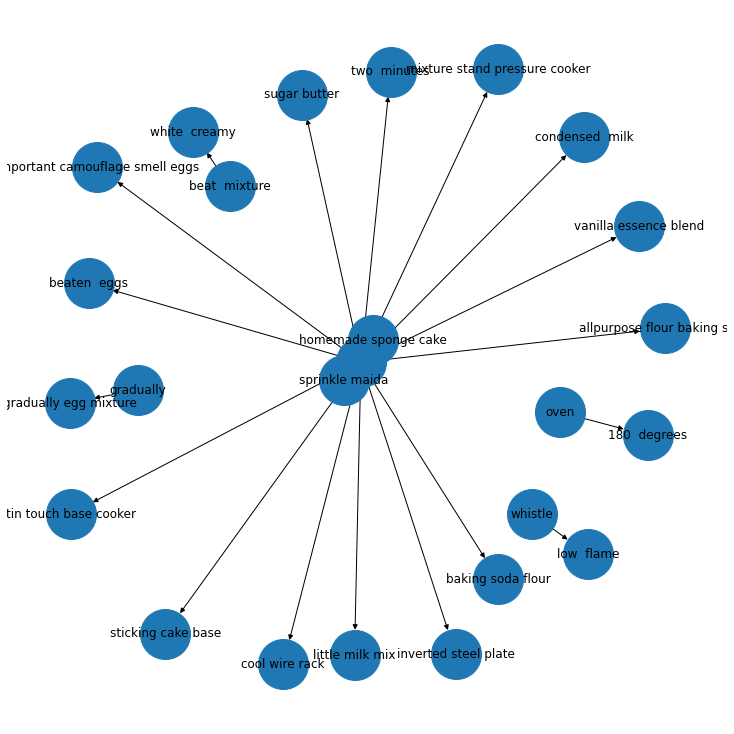

In [34]:
G=nx.from_pandas_edgelist(knowledge_graph_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

In [35]:
G = nx.from_pandas_edgelist(knowledge_graph_df[knowledge_graph_df,source = 'source', target = 'target', edge_attr = True, create_using= nx.MultiDiGraph())
#MultiDIGRaph because its a directional graph
plt.figure(figsize = (10,10))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

SyntaxError: invalid syntax (<ipython-input-35-816b42df2f34>, line 1)

In [ ]:
G=nx.from_pandas_edgelist(knowledge_graph_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize = (15,15))
pox = nx.spring_layout(G,k = 1.0) #k defines the distnace between nodes
nx.draw(G, with_labels= True, node_size = 2500)
plt.show()

In [ ]:
print(G.nodes)

In [ ]:
print(G.edges)

In [ ]:
print(G.neighbors("homemade sponge cake"))

In [ ]:
for i in G.neighbors("gradually egg mixture"):
    print(i)